# Field-Level Inference - Test Notebook

This notebook provides a **simple test** of the field-level inference pipeline on CPU.

**Purpose**: Educational and debugging tool to understand the workflow.

**Key differences from production script**:
- Small mesh (8³) for fast execution
- CPU-only (no parallelization)
- Hard-coded test parameters (no YAML)
- Single chain MCLMC sampler
- Minimal warmup/samples for quick testing

**Workflow**:
1. Create model with test configuration
2. Generate synthetic observations
3. Two-stage warmup (mesh only, then all parameters)
4. Sample with MCLMC
5. Visualize results

**For production runs**: Use `scripts/04_field_level_inference.py` with YAML config and GPU parallelization.

## 1. Imports and Setup

In [7]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
from blackjax.adaptation.mclmc_adaptation import MCLMCAdaptationState

from desi_cmb_fli.model import FieldLevelModel, default_config
from desi_cmb_fli.samplers import get_mclmc_run, get_mclmc_warmup

jax.config.update("jax_enable_x64", True)

print(f"JAX version: {jax.__version__}")
print(f"Backend: {jax.default_backend()}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.0
Backend: cpu
Devices: [CpuDevice(id=0)]


## 2. Model Configuration (Test Parameters)

In [8]:
# Test configuration (small mesh for fast CPU execution)
model_config = default_config.copy()
model_config["mesh_shape"] = (8, 8, 8)
model_config["box_shape"] = (200.0, 200.0, 200.0)  # Mpc/h
model_config["evolution"] = "lpt"
model_config["lpt_order"] = 2
model_config["a_obs"] = 0.5
model_config["gxy_density"] = 0.001  # [h³/Mpc³]

model = FieldLevelModel(**model_config)
print(model)

# CONFIG
{'a_obs': 0.5,
 'box_shape': array([200., 200., 200.]),
 'evolution': 'lpt',
 'gxy_density': 0.001,
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'loc_fid': 0.3111,
                         'low': 0.05,
                         'scale': 0.5,
                         'scale_fid': 0.02},
             'b1': {'group': 'bias',
                    'label': '{b}_1',
                    'loc': 1.0,
                    'loc_fid': 1.0,
                    'scale': 0.5,
                    'scale_fid': 0.04},
             'b2': {'group': 'bias',
                    'label': '{b}_2',
                    'loc': 0.0,
                    'loc_fid': 0.0,
                    'scale': 2.0,
                    'scale_fid': 0.02},
             'bn2': {'group': 'bias',
                     'label': '{b}_{\\nabla^2}',
                     'loc': 0.0,
 

## 3. Generate Synthetic Truth

In [9]:
# Truth parameters for synthetic data
truth_params = {
    "Omega_m": 0.3,
    "sigma8": 0.8,
    "b1": 1.0,
    "b2": 0.0,
    "bs2": 0.0,
    "bn2": 0.0,
}

# Generate truth
seed = 42
truth = model.predict(
    samples=truth_params,
    hide_base=False,
    hide_samp=False,
    frombase=True,
    rng=jr.key(seed),
)

print(f"Obs shape: {truth['obs'].shape}")
print(f"Mean count: {jnp.mean(truth['obs']):.4f}")
print(f"Std: {jnp.std(truth['obs']):.4f}")

Obs shape: (8, 8, 8)
Mean count: 0.9980
Std: 1.1429


## 4. Visualize Observations

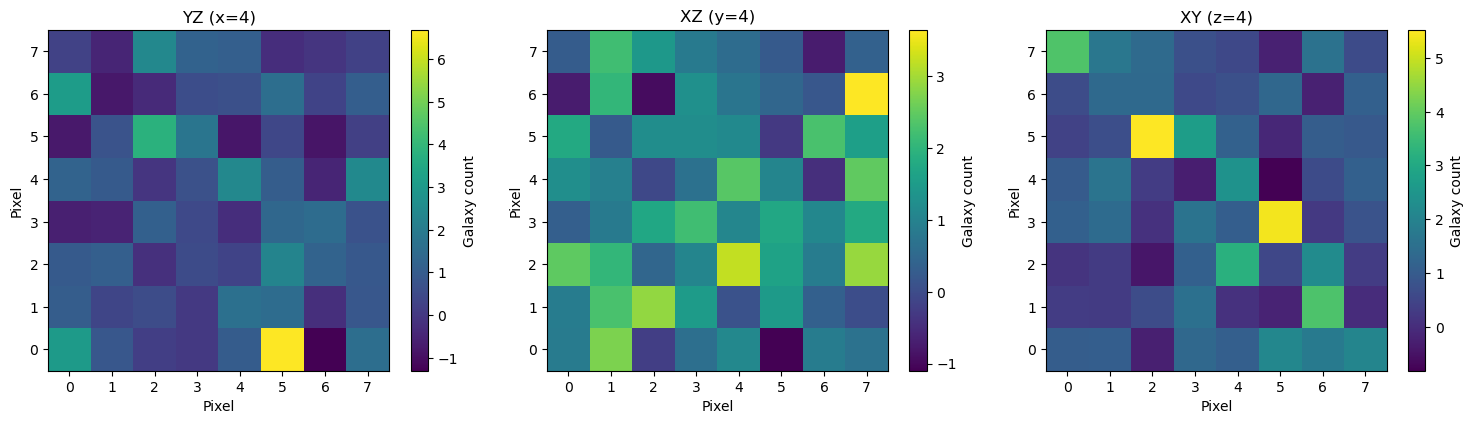

In [10]:
# Visualize observed field (3 orthogonal slices)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
center_idx = model_config["mesh_shape"][0] // 2
slices = [
    truth["obs"][center_idx, :, :],
    truth["obs"][:, center_idx, :],
    truth["obs"][:, :, center_idx],
]
titles = [f"YZ (x={center_idx})", f"XZ (y={center_idx})", f"XY (z={center_idx})"]

for ax, data, title in zip(axes, slices, titles, strict=True):
    im = ax.imshow(data, origin="lower", cmap="viridis")
    ax.set_title(title)
    ax.set_xlabel("Pixel")
    ax.set_ylabel("Pixel")
    plt.colorbar(im, ax=ax, label="Galaxy count")

plt.tight_layout()
plt.show()

## 5. MCLMC Inference (Following Benchmark)

We follow the exact structure from benchmark-field-level:
1. **Stage 1**: Warmup mesh only (2^10 steps, cosmo/bias fixed at fiducial)
2. **Stage 2**: Warmup all parameters (minimal steps for testing)
3. **Stage 3**: Sample (minimal samples for testing)

**Note**: This is a minimal test. For production, use `scripts/04_field_level_inference.py`.

### Stage 1: Warmup Mesh Only

In [11]:
# Condition model with obs + fiducial cosmo/bias (freeze non-mesh params)
model.reset()
model.condition({"obs": truth["obs"]} | model.loc_fid, frombase=True)
model.block()

# Initialize from Kaiser posterior
init_params_ = model.kaiser_post(jr.key(45), delta_obs=truth["obs"] - 1)
init_mesh_ = {k: init_params_[k] for k in ["init_mesh_"]}

# Warmup mesh only (2^10 steps, as in benchmark)
print("Warming mesh only (2^10 steps, cosmo/bias fixed)...")
warmup_mesh_fn = get_mclmc_warmup(
    model.logpdf,
    n_steps=2**10,
    config=None,
    desired_energy_var=1e-6,
    diagonal_preconditioning=False,
)

state_mesh, config_mesh = warmup_mesh_fn(jr.key(43), init_mesh_)

print("✓ Mesh warmup done")
print(f"  Logdens: {state_mesh.logdensity:.2f}")
print(f"  L: {config_mesh.L:.6f}")
print(f"  step_size: {config_mesh.step_size:.6f}")

# Update init params with warmed mesh
init_params_ |= state_mesh.position

Warming mesh only (2^10 steps, cosmo/bias fixed)...
Performed 1024.0 adaptation steps
✓ Mesh warmup done
Performed 1024.0 adaptation steps
✓ Mesh warmup done
  Logdens: -1357.62
  L: 21.391981
  step_size: 1.015092
  Logdens: -1357.62
  L: 21.391981
  step_size: 1.015092


### Stage 2: Warmup All Parameters

In [12]:
# Reset and condition with obs only (all params free)
model.reset()
model.condition({"obs": truth["obs"]})
model.block()

# Warmup all params (minimal steps for testing)
num_warmup = 50  # Reduced for testing
print(f"Warming all params ({num_warmup} steps)...")

warmup_all_fn = get_mclmc_warmup(
    model.logpdf,
    n_steps=num_warmup,
    config=None,
    desired_energy_var=5e-4,
    diagonal_preconditioning=False,
)

state, config = warmup_all_fn(jr.key(43), init_params_)

print("✓ Full warmup done")
print(f"  Logdens: {state.logdensity:.2f}")
print(f"  Adapted L: {config.L:.6f}")
print(f"  step_size: {config.step_size:.6f}")

# Recalculate L (benchmark approach for efficiency)
eval_per_ess = 1e3
recalc_L = 0.4 * eval_per_ess / 2 * config.step_size

config = MCLMCAdaptationState(
    L=recalc_L, step_size=config.step_size, inverse_mass_matrix=config.inverse_mass_matrix
)

print(f"\n  Recalculated L: {recalc_L:.6f}")

Warming all params (50 steps)...
Performed 50.0 adaptation steps
✓ Full warmup done
Performed 50.0 adaptation steps
✓ Full warmup done
  Logdens: -1376.63
  Adapted L: 19.524377
  step_size: 7.524622

  Recalculated L: 1504.924349
  Logdens: -1376.63
  Adapted L: 19.524377
  step_size: 7.524622

  Recalculated L: 1504.924349


### Stage 3: Sample

In [15]:
# Sample (minimal for testing)
num_samples = 50  # Reduced for testing
print(f"Sampling {num_samples} steps...")

run_fn = get_mclmc_run(
    model.logpdf,
    n_samples=num_samples,
    thinning=1,
    progress_bar=False,  # Disable progress bar for notebook compatibility
)

state, samples_dict = run_fn(jr.key(42), state, config)

print("\n✓ Sampling done!")
print(f"  Mean MSE/dim: {jnp.mean(samples_dict['mse_per_dim']):.6e}")
print(f"  Final logdensity: {state.logdensity:.2f}")

# Extract parameter samples (exclude diagnostics)
samples = {}
param_names = [k for k in samples_dict.keys() if k not in ["logdensity", "mse_per_dim"]]
for p in param_names:
    samples[p] = samples_dict[p]

print(f"\nSampled parameters: {param_names}")

Sampling 50 steps...

✓ Sampling done!

✓ Sampling done!
  Mean MSE/dim: 5.627133e-04
  Final logdensity: -1452.41

Sampled parameters: ['Omega_m_', 'b1_', 'b2_', 'bn2_', 'bs2_', 'init_mesh_', 'sigma8_', 'n_evals']
  Mean MSE/dim: 5.627133e-04
  Final logdensity: -1452.41

Sampled parameters: ['Omega_m_', 'b1_', 'b2_', 'bn2_', 'bs2_', 'init_mesh_', 'sigma8_', 'n_evals']


## 6. Analyze Results

In [16]:
# Compare recovered parameters to truth
comp_params = ["Omega_m", "sigma8", "b1", "b2", "bs2", "bn2"]

print("Parameter recovery:")
print(f"{'Param':<10} {'Truth':<10} {'Mean':<10} {'Std':<10} {'Bias(σ)':<10}")
print("-" * 60)

for p in comp_params:
    pk = p + "_"
    if pk in samples:
        vals = samples[pk]  # Already 1D for single chain
        mean, std = np.mean(vals), np.std(vals)
        truth_val = truth_params[p]
        bias = (mean - truth_val) / std if std > 0 else 0
        print(f"{p:<10} {truth_val:<10.4f} {mean:<10.4f} {std:<10.4f} {bias:<10.2f}")

Parameter recovery:
Param      Truth      Mean       Std        Bias(σ)   
------------------------------------------------------------
Omega_m    0.3000     -1.1569    2.0120     -0.72     
sigma8     0.8000     11.6695    3.3914     3.21      
b1         1.0000     -6.3987    0.8638     -8.57     
b2         0.0000     -6.7976    2.3040     -2.95     
bs2        0.0000     0.6522     2.0866     0.31      
bn2        0.0000     7.7926     2.5726     3.03      


## 7. Visualizations

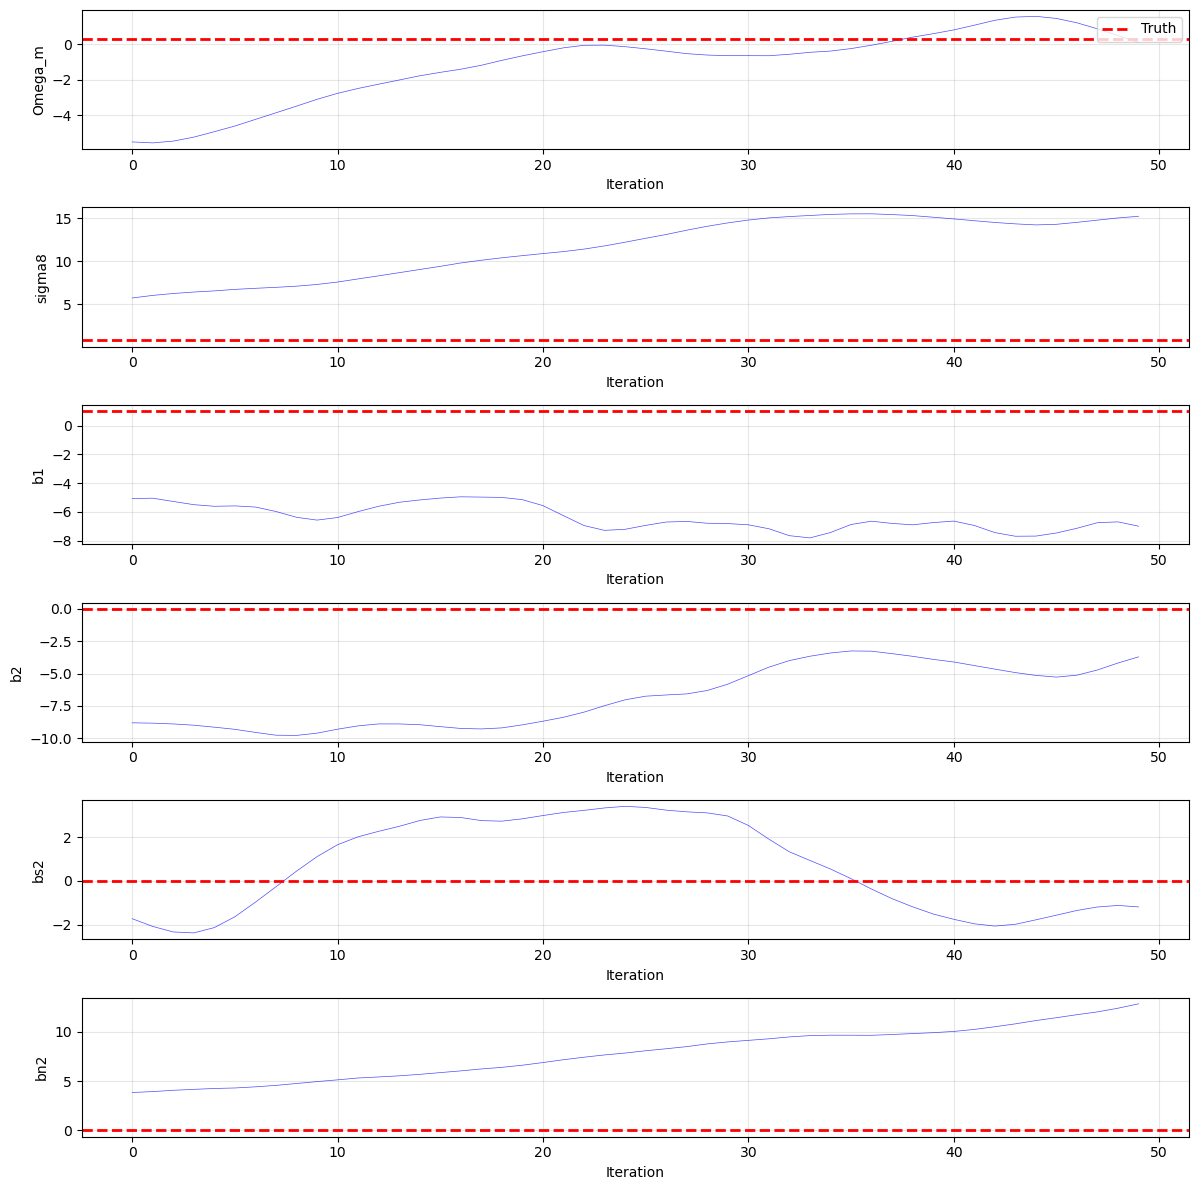

In [17]:
# Trace plots
fig, axes = plt.subplots(len(comp_params), 1, figsize=(12, 2 * len(comp_params)))

for i, p in enumerate(comp_params):
    pk = p + "_"
    if pk in samples:
        ax = axes[i]
        ax.plot(samples[pk], alpha=0.7, lw=0.5, color="blue")
        ax.axhline(truth_params[p], color="red", ls="--", lw=2, label="Truth")
        ax.set_ylabel(p)
        ax.set_xlabel("Iteration")
        if i == 0:
            ax.legend(loc="upper right")
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

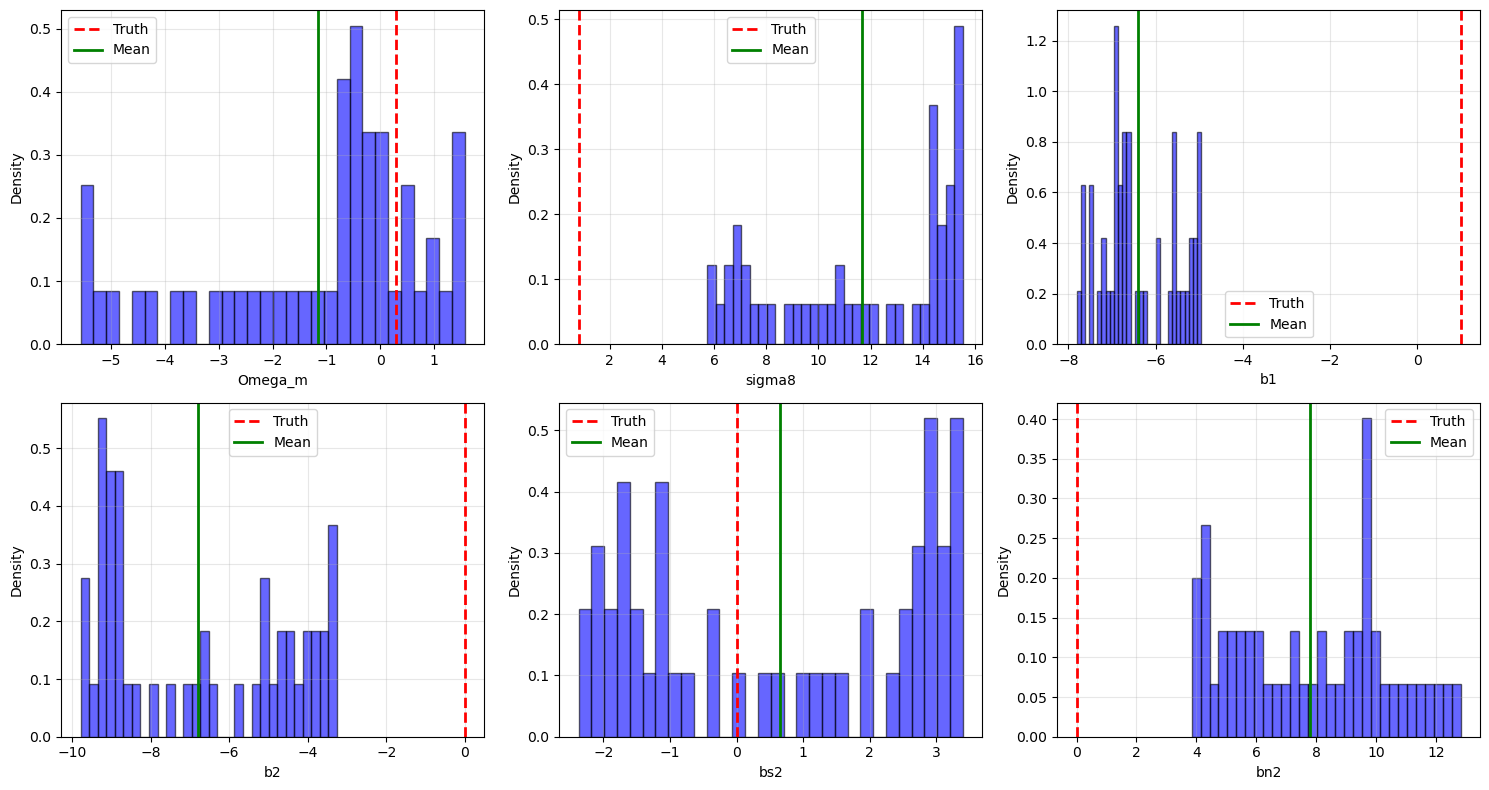

In [18]:
# Posterior distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, p in enumerate(comp_params):
    pk = p + "_"
    if pk in samples:
        ax = axes[i]
        vals = samples[pk]

        ax.hist(vals, bins=30, density=True, alpha=0.6, color="blue", edgecolor="black")
        ax.axvline(truth_params[p], color="red", ls="--", lw=2, label="Truth")
        ax.axvline(np.mean(vals), color="green", ls="-", lw=2, label="Mean")

        ax.set_xlabel(p)
        ax.set_ylabel("Density")
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

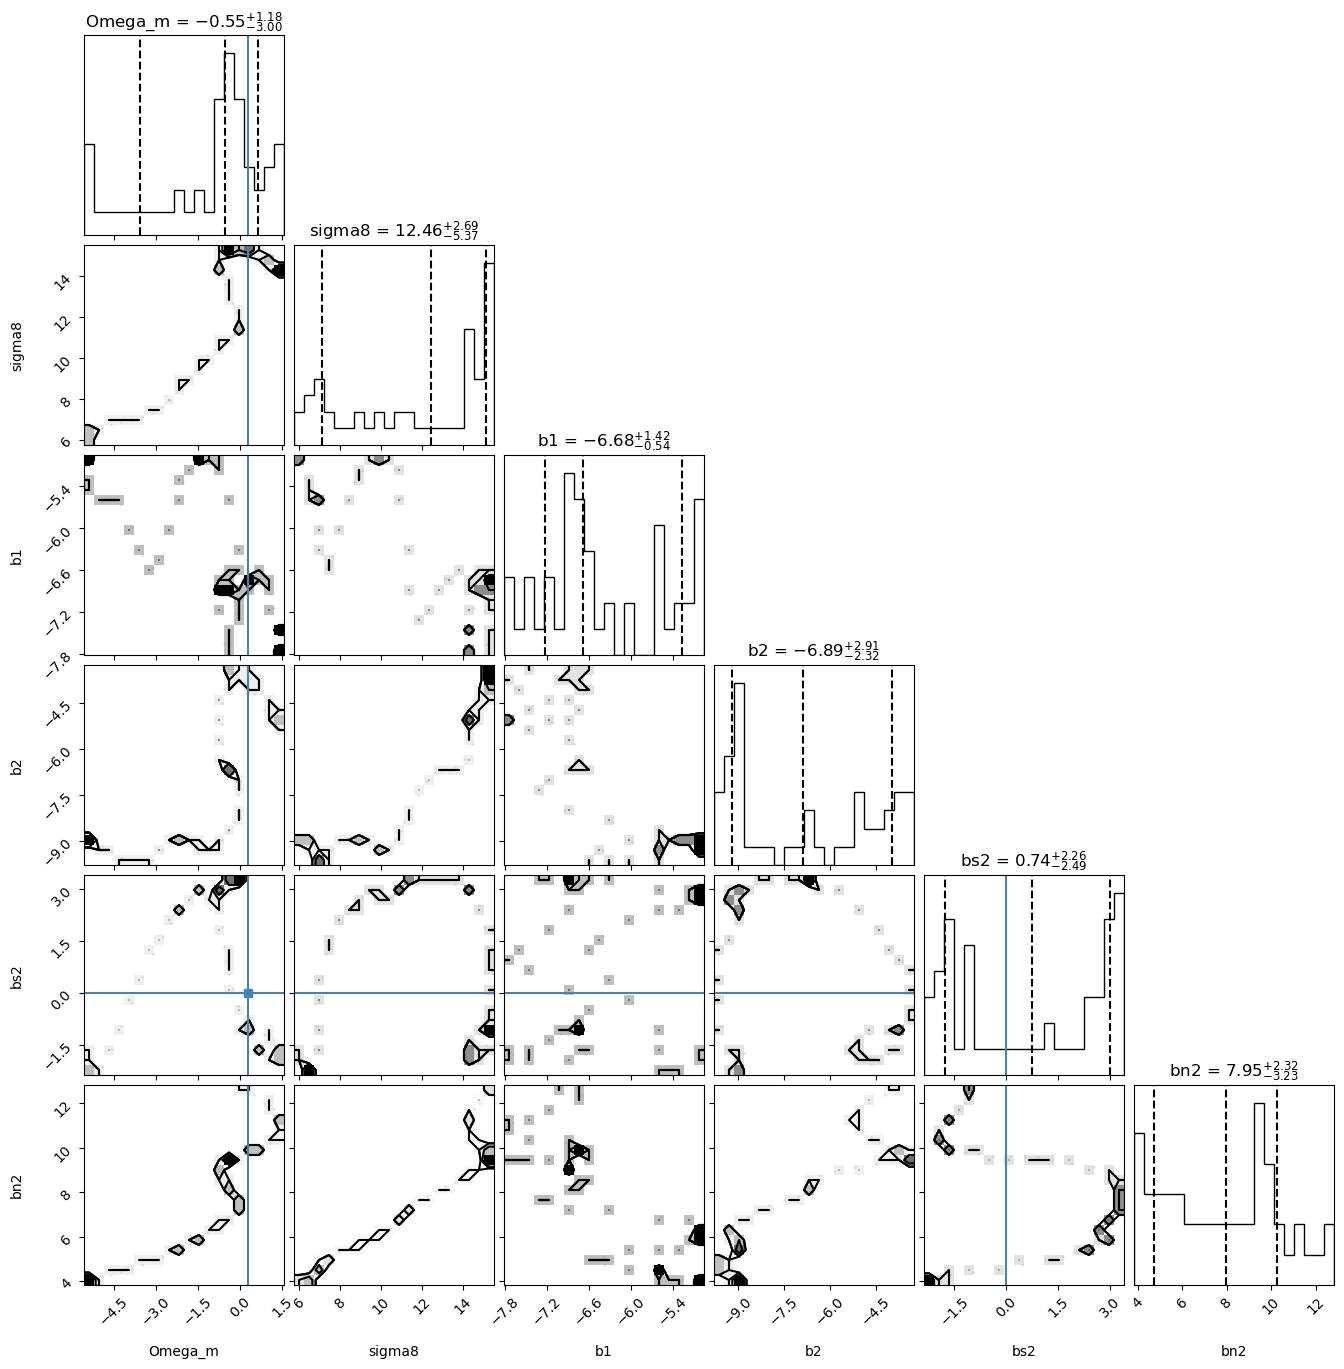

In [19]:
# Corner plot (optional)
try:
    import corner

    labels, data_list, truths = [], [], []
    for p in comp_params:
        pk = p + "_"
        if pk in samples:
            labels.append(p)
            data_list.append(samples[pk])
            truths.append(truth_params[p])

    data = np.column_stack(data_list)
    fig = corner.corner(
        data,
        labels=labels,
        truths=truths,
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        title_kwargs={"fontsize": 12},
    )
    plt.show()

except ImportError:
    print("⚠️  Corner plot requires 'corner' package. Install with: pip install corner")

## Summary

This notebook demonstrated the **complete field-level inference pipeline** following benchmark-field-level:

1. ✅ Model creation with test configuration (small 8³ mesh)
2. ✅ Synthetic truth generation
3. ✅ Two-stage MCLMC warmup (mesh only, then all parameters)
4. ✅ Sampling with MCLMC
5. ✅ Parameter recovery analysis
6. ✅ Visualizations (traces, posteriors, corner plot)

**Key takeaways**:
- MCLMC sampler follows exact benchmark structure
- Two-stage warmup is critical: mesh first (frozen cosmo/bias), then all params
- `model.block()` must be called after `model.condition()` to hide deterministic sites
- Kaiser initialization with `delta_obs = obs - 1` (obs is 1+delta)
- L recalculation for efficiency: `0.4 * eval_per_ess / 2 * step_size`

**For production runs**:
- Use `scripts/04_field_level_inference.py` with YAML configuration
- Enable GPU parallelization with `jit(vmap(...))`
- Use larger mesh (e.g., 64³) and more samples
- Run on NERSC Perlmutter with SLURM